In [2]:
#기본 라이브러리 설치
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  #plot내 글씨를 선명하게 해주는 옵션

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer,StandardScaler,OneHotEncoder

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

In [3]:
#결측치만 처리한 데이터 불러오기
df = pd.read_csv('C:/Users/user/OneDrive/바탕 화면/비어플/processed_data.csv',encoding='EUC-KR')
df

,Date,Rented Bike Count,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Month,T-H,Daytime,DayOfWeek,IsWeekend
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes,12,-17.8,Dawn,4,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes,12,-17.9,Dawn,4,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,Winter,No Holiday,Yes,12,-18.2,Dawn,4,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,Winter,No Holiday,Yes,12,-18.2,Dawn,4,0
4,2017-12-01,78,4,-6.0,36,1.2,2000,-18.6,0.00,0.0,0.0,Winter,No Holiday,Yes,12,-18.8,Dawn,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7003,2018-11-30,1047,17,6.0,29,2.1,1877,-10.7,0.23,0.0,0.0,Autumn,No Holiday,Yes,11,-8.2,Afternoon,4,0
7004,2018-11-30,1384,18,4.7,34,1.9,1661,-9.8,0.00,0.0,0.0,Autumn,No Holiday,Yes,11,-8.5,Evening,4,0
7005,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.00,0.0,0.0,Autumn,No Holiday,Yes,11,-9.0,Evening,4,0
7006,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.00,0.0,0.0,Autumn,No Holiday,Yes,11,-9.6,Evening,4,0


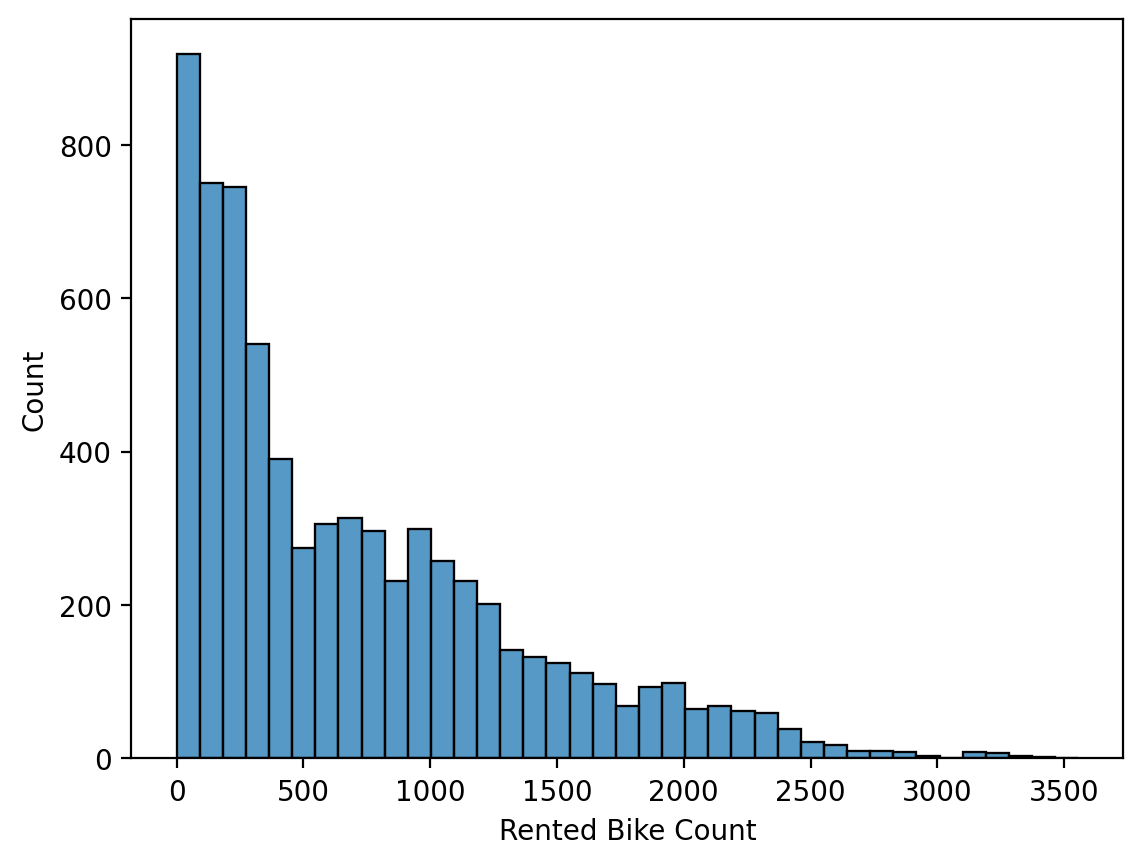

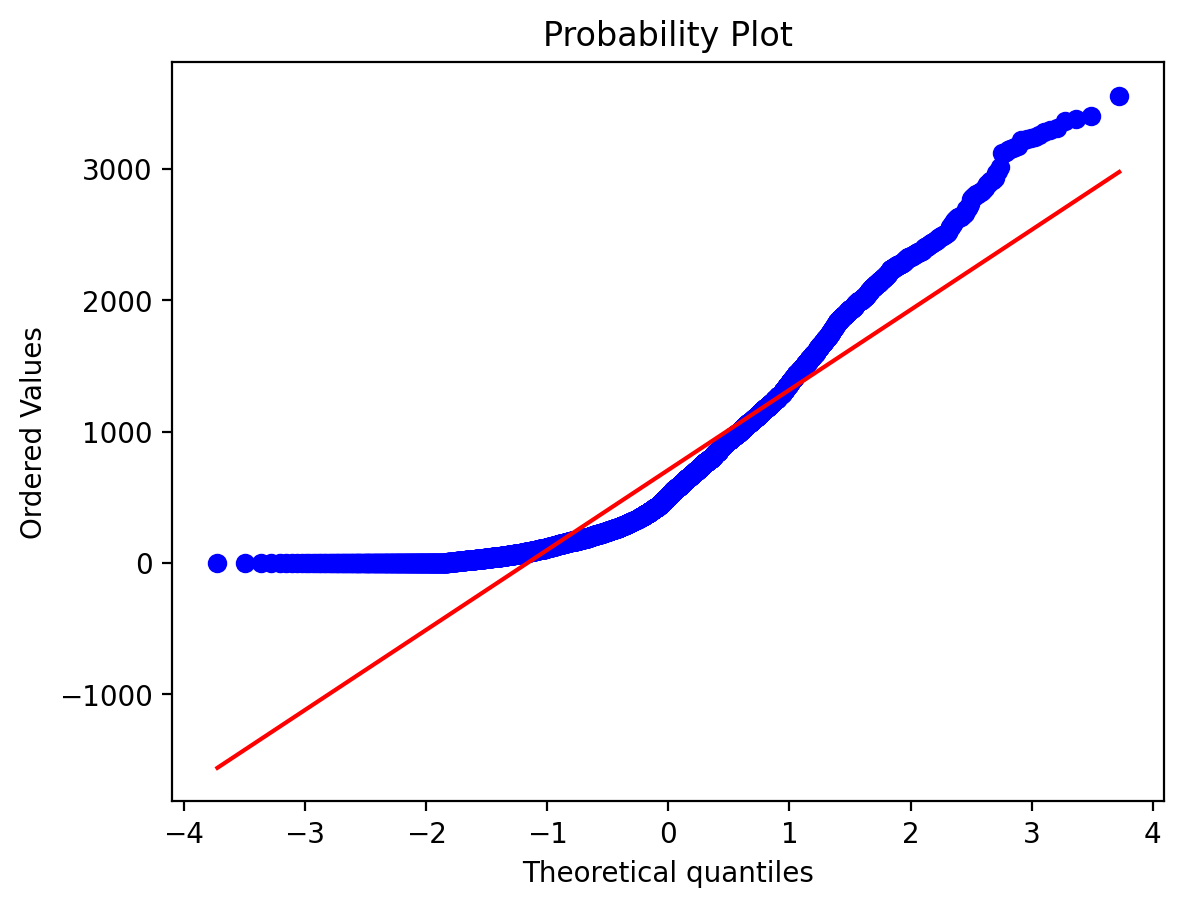

In [4]:
sns.histplot(df['Rented Bike Count']) #정규성을 띄지 않음.
plt.show()
stats.probplot(df['Rented Bike Count'], dist="norm", plot=plt) # Q-Q plot그려보기
plt.show()

In [6]:
#train_set와 valid_set으로 나누기
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42) # valid set 15%

In [7]:
yeojohnson_y = PowerTransformer(method='yeo-johnson', standardize=True)

train_set['Rented Bike Count_org'] = train_set['Rented Bike Count'] #inverse_transform을 하기 위해선 열이름이 같아야하므로 원본을 따로 저장
train_set['Rented Bike Count'] = yeojohnson_y.fit_transform(pd.DataFrame(train_set['Rented Bike Count'])).flatten()

###### boxcox는 0인값이 있으면 변환이 안되므로 yeojohnson방법 사용

In [8]:
print(train_set['Rented Bike Count_org']) 
pd.Series(yeojohnson_y.inverse_transform(pd.DataFrame(train_set['Rented Bike Count'])).flatten()) # 바꿨을 때 값이 같은지 확인 => 거의 같은듯? 약간의 오차 존재

1741       7
3105      11
1869     441
4643    2016
387       84
        ... 
3772     317
5191     171
5226     381
5390    1107
860      122
Name: Rented Bike Count_org, Length: 5606, dtype: int64


0          7.0
1         11.0
2        441.0
3       2016.0
4         84.0
         ...  
5601     317.0
5602     171.0
5603     381.0
5604    1107.0
5605     122.0
Length: 5606, dtype: float64

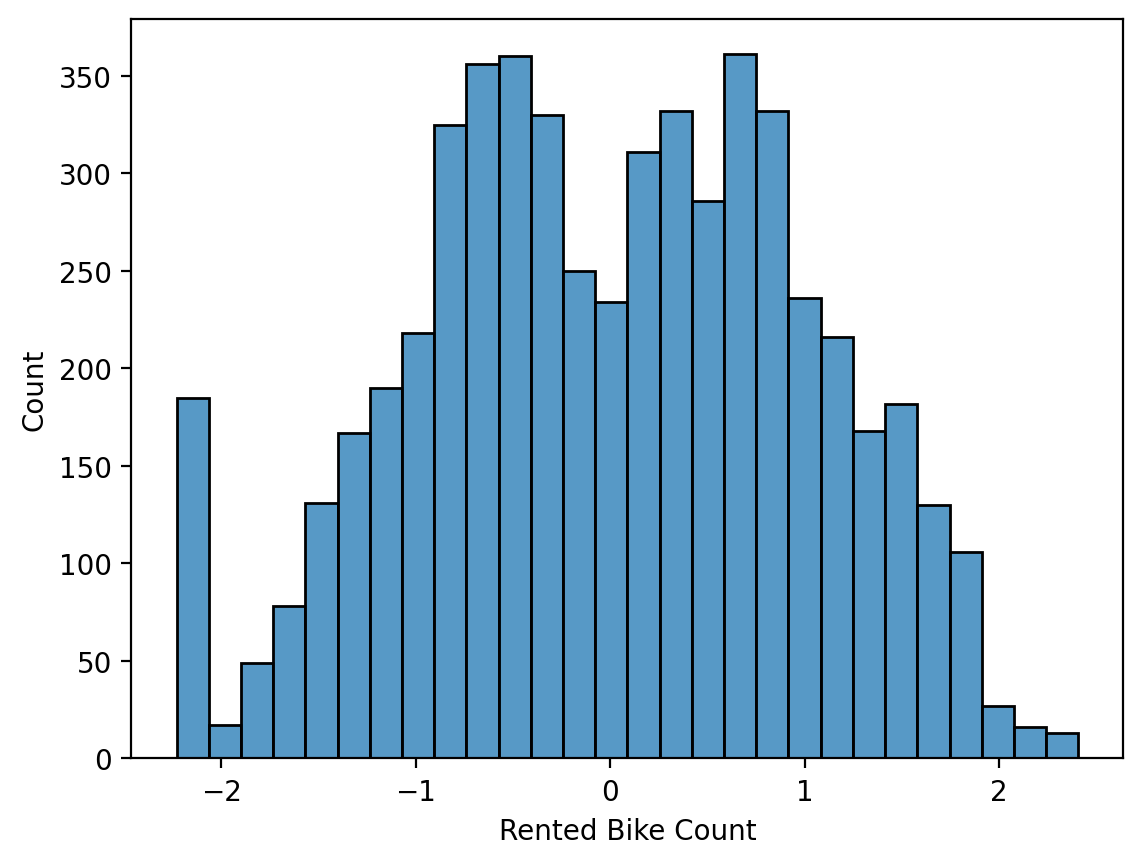

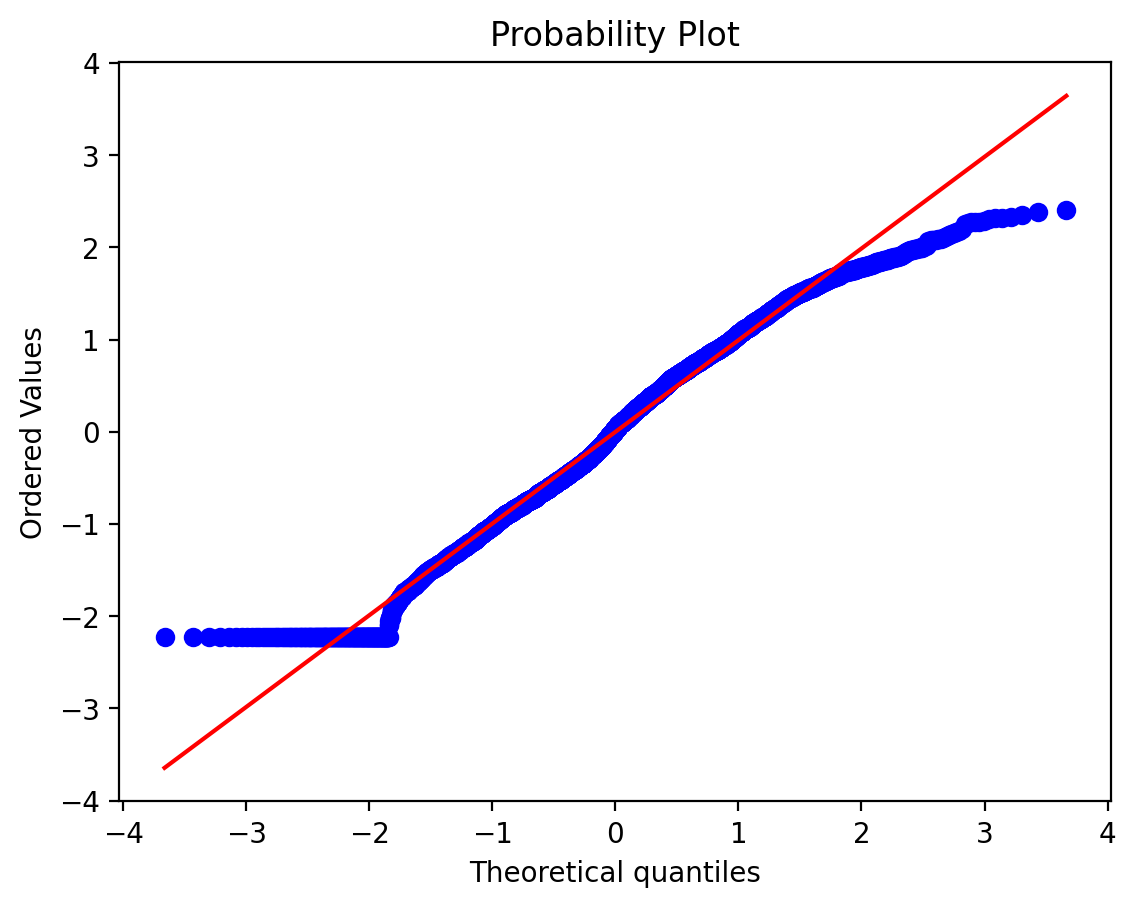

In [9]:
sns.histplot(train_set['Rented Bike Count']) 
plt.show()
stats.probplot(train_set['Rented Bike Count'], dist="norm", plot=plt) # Q-Q plot그려보기
plt.show()

###### 전보다 확실히 좋아짐

In [10]:
trainset = train_set.drop(columns=['Rented Bike Count','Date'], axis = 1)
train_y = train_set['Rented Bike Count']

validset = valid_set.drop(columns=['Rented Bike Count','Date'], axis = 1)
valid_y = valid_set['Rented Bike Count']

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# 열 정의
onehot_at = ['Seasons', 'Holiday', 'Functioning Day', 'Daytime']
num_at = ['Temperature(째C)','Humidity(%)','Wind speed (m/s)','Visibility (10m)','Dew point temperature(째C)','Solar Radiation (MJ/m2)',
          'Rainfall(mm)','Snowfall (cm)','T-H']


# 원-핫 인코딩 파이프라인 : 고용형태
onehot_pipeline = Pipeline([
    ("encode", OneHotEncoder(handle_unknown="ignore"))  
]) 

# 숫자형 데이터 파이프라인
num_pipeline = Pipeline([
    ("standardize", StandardScaler())
])


# 전체 파이프라인
preprocessing = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_at),
        ("onehot", onehot_pipeline, onehot_at),
    ]
)

# 훈련 데이터
train1 = preprocessing.fit_transform(trainset)

In [13]:
feature_names = preprocessing.get_feature_names_out()
train_x= pd.DataFrame(data = train1, columns = feature_names)
train_x

,num__Temperature(째C),num__Humidity(%),num__Wind speed (m/s),num__Visibility (10m),num__Dew point temperature(째C),num__Solar Radiation (MJ/m2),num__Rainfall(mm),num__Snowfall (cm),num__T-H,onehot__Seasons_Autumn,...,onehot__Seasons_Summer,onehot__Seasons_Winter,onehot__Holiday_Holiday,onehot__Holiday_No Holiday,onehot__Functioning Day_No,onehot__Functioning Day_Yes,onehot__Daytime_Afternoon,onehot__Daytime_Dawn,onehot__Daytime_Evening,onehot__Daytime_Morning
0,-0.636316,1.414201,1.347657,-1.853433,-0.100735,-0.566576,3.679322,-0.168463,-0.140527,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1,-0.051353,1.905590,-0.899730,-1.975094,0.588175,-0.498674,1.564414,-0.168463,0.539960,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.413473,-0.747908,-0.020318,0.772130,-0.605936,1.312022,-0.127513,-0.168463,-0.604266,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.859526,-0.747908,-0.802017,0.921739,1.269430,-0.181802,-0.127513,-0.168463,1.452317,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.483119,1.610756,-0.606592,-1.929060,-0.774336,-0.657110,-0.127513,5.053159,-0.846217,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,0.330266,0.234869,-0.704305,0.921739,0.435083,-0.657110,-0.127513,-0.168463,0.371099,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5602,0.965368,1.414201,2.031645,0.897079,1.376594,-0.657110,-0.127513,-0.168463,1.308658,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5603,0.873445,1.021090,-1.290580,-0.648338,1.177575,-0.657110,-0.127513,-0.168463,1.104512,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5604,0.522468,-0.256519,0.810239,0.921739,0.396811,-0.657110,-0.127513,-0.168463,0.393782,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [13]:
train_y

1741   -1.929894
3105   -1.841102
1869   -0.122766
4643    1.574754
387    -1.176767
          ...   
3772   -0.385121
5191   -0.799959
5226   -0.242797
5390    0.794348
860    -0.990964
Name: Rented Bike Count, Length: 5606, dtype: float64

In [14]:
# valid data 전처리
valid_x = preprocessing.transform(validset)
feature_names = preprocessing.get_feature_names_out()
valid_x= pd.DataFrame(data = valid_x, columns = feature_names)
valid_x

,num__Temperature(째C),num__Humidity(%),num__Wind speed (m/s),num__Visibility (10m),num__Dew point temperature(째C),num__Solar Radiation (MJ/m2),num__Rainfall(mm),num__Snowfall (cm),num__T-H,onehot__Seasons_Autumn,...,onehot__Seasons_Summer,onehot__Seasons_Winter,onehot__Holiday_Holiday,onehot__Holiday_No Holiday,onehot__Functioning Day_No,onehot__Functioning Day_Yes,onehot__Daytime_Afternoon,onehot__Daytime_Dawn,onehot__Daytime_Evening,onehot__Daytime_Morning
0,0.906872,0.873674,0.175107,-0.260339,1.154612,-0.566576,-0.127513,-0.168463,1.089390,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.480685,0.726257,-0.313455,-0.615456,0.733611,-0.657110,-0.127513,-0.168463,0.658415,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-1.633538,-1.337574,-0.606592,0.921739,-1.914865,-0.657110,-0.127513,-0.168463,-1.889630,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.112635,-0.600491,-0.899730,0.921739,-0.292099,-0.600526,-0.127513,-0.168463,-0.286705,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.798236,-0.747908,-1.290580,0.921739,0.389156,-0.657110,-0.127513,-0.168463,0.492074,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,1.165927,-0.453075,0.565957,-0.377068,0.848429,1.289389,-0.127513,-0.168463,0.915488,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1398,1.103252,0.824535,-0.606592,-0.676287,1.277084,0.723546,-0.127513,-0.168463,1.251951,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1399,-0.839660,1.315923,-0.248313,-0.722320,-0.269136,-0.430773,-0.127513,8.138662,-0.354754,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1400,-2.176718,-0.207381,-0.997442,-0.115662,-1.876592,-0.657110,-0.127513,-0.168463,-2.033288,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [17]:
# 모델 초기화
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet Regression": ElasticNet(),
    "Random Forest Regression": RandomForestRegressor(),
    "Gradient Boosting Regression": GradientBoostingRegressor(),
    "Support Vector Regression": SVR()
}

# 모델 학습 및 성능 평가
results = {}
for name, model in models.items():
    # 모델 학습
    model.fit(train_x, train_y)
    
    # 예측
    y_pred = model.predict(valid_x)
    
    # 성능 평가
    mse = mean_squared_error(valid_y, y_pred)
    mae = mean_absolute_error(valid_y, y_pred)
    r2 = r2_score(valid_y, y_pred)
    
    # 결과 저장
    results[name] = {
        "Mean squared Error" : mse,
        "Mean Absolute Error": mae,
        "R^2 Score": r2
    }

# 결과 출력
results_df = pd.DataFrame(results).T.sort_values(by="R^2 Score")
print(results_df)

                              Mean squared Error  Mean Absolute Error  \
Lasso Regression                   914509.719686           692.010699   
ElasticNet Regression              914498.942091           692.011439   
Linear Regression                  913695.062486           692.031276   
Ridge Regression                   913693.959106           692.031471   
Gradient Boosting Regression       913545.588937           692.036072   
Support Vector Regression          913511.705068           692.053532   
Random Forest Regression           913469.644627           692.036624   

                              R^2 Score  
Lasso Regression              -1.099276  
ElasticNet Regression         -1.099252  
Linear Regression             -1.097406  
Ridge Regression              -1.097404  
Gradient Boosting Regression  -1.097063  
Support Vector Regression     -1.096985  
Random Forest Regression      -1.096889  


#### 성능이 제일 좋은 GBM모델과 랜포 모델을 선택

#### 랜덤포레스트

In [18]:
#랜덤포레스트 회귀
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import randint




# 랜덤 서치로 간단한 범위 압축
forest_reg = RandomForestRegressor(random_state=42)

param_distributions = {
    'max_features': ['auto', 'sqrt', 'log2'],    # 각 트리가 사용하는 최대 특성 수
    'max_depth': randint(1, 30),                 # 트리의 최대 깊이
    'min_samples_split': randint(2, 20),          # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': randint(3, 20)            # 리프 노드에 있어야 하는 최소 샘플 수
}

random_search = RandomizedSearchCV(estimator=forest_reg, param_distributions=param_distributions,
                           cv=15, n_jobs=-1, verbose=2, scoring='r2')
# 모델 학습
random_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 찾기
print("Best parameters found: ", random_search.best_params_)
print("Best r2 score: {:.2f}".format(random_search.best_score_))

Fitting 15 folds for each of 10 candidates, totalling 150 fits


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
30 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File

Best parameters found:  {'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 16}
Best r2 score: 0.85


In [19]:
forest_reg = RandomForestRegressor(random_state=42)

param_grid = {
    'max_features': ['auto', 'sqrt', 'log2'],    # 각 트리가 사용하는 최대 특성 수
    'max_depth': [28,31,33,35,37],                 # 트리의 최대 깊이
    'min_samples_split': [11,13,15],          # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': [5, 7,9,11]           # 리프 노드에 있어야 하는 최소 샘플 수
}

random_search = GridSearchCV(estimator=forest_reg, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='r2')
# 모델 학습
random_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 찾기
print("Best parameters found: ", random_search.best_params_)
print("Best r2 score: {:.2f}".format(random_search.best_score_))

Fitting 5 folds for each of 180 candidates, totalling 900 fits


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
178 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  Fi

Best parameters found:  {'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 13}
Best r2 score: 0.84


###### 최적의 파라미터 'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 11 로 랜포모델 생성

In [16]:
forest_reg = RandomForestRegressor(bootstrap= True, max_depth=28, max_features= "sqrt" , min_samples_leaf=5, min_samples_split = 11, random_state=42)

forest_reg.fit(train_x, train_y)


RandomForestRegressor(max_depth=28, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=11, random_state=42)

In [21]:
# 예측
y_pred = forest_reg.predict(train_x)
y_pred2 = forest_reg.predict(valid_x)
y_pred2 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred2)).flatten()
    
# 성능 평가

# in train set
mse1 = mean_squared_error(train_y, y_pred)
mae1 = mean_absolute_error(train_y, y_pred)
r21= r2_score(train_y, y_pred)

# in valid set
mse2 = mean_squared_error(valid_y, y_pred2)
mae2 = mean_absolute_error(valid_y, y_pred2)
r22 = r2_score(valid_y, y_pred2)    



# 결과 저장
results = {
    "Metric": ["Mean Squared Error", "Mean Absolute Error", "R^2 Score"],
    "Train Set": [mse1, mae1, r21],
    "Validation Set": [mse2, mae2, r22]
}

# DataFrame으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)


                Metric  Train Set  Validation Set
0   Mean Squared Error   0.101101    79320.604742
1  Mean Absolute Error   0.239738      180.650534
2            R^2 Score   0.898899        0.817918


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


###### trainset에서는 0.87 valid에서는 0.82로 나쁘지  않은 R2가 나왔다

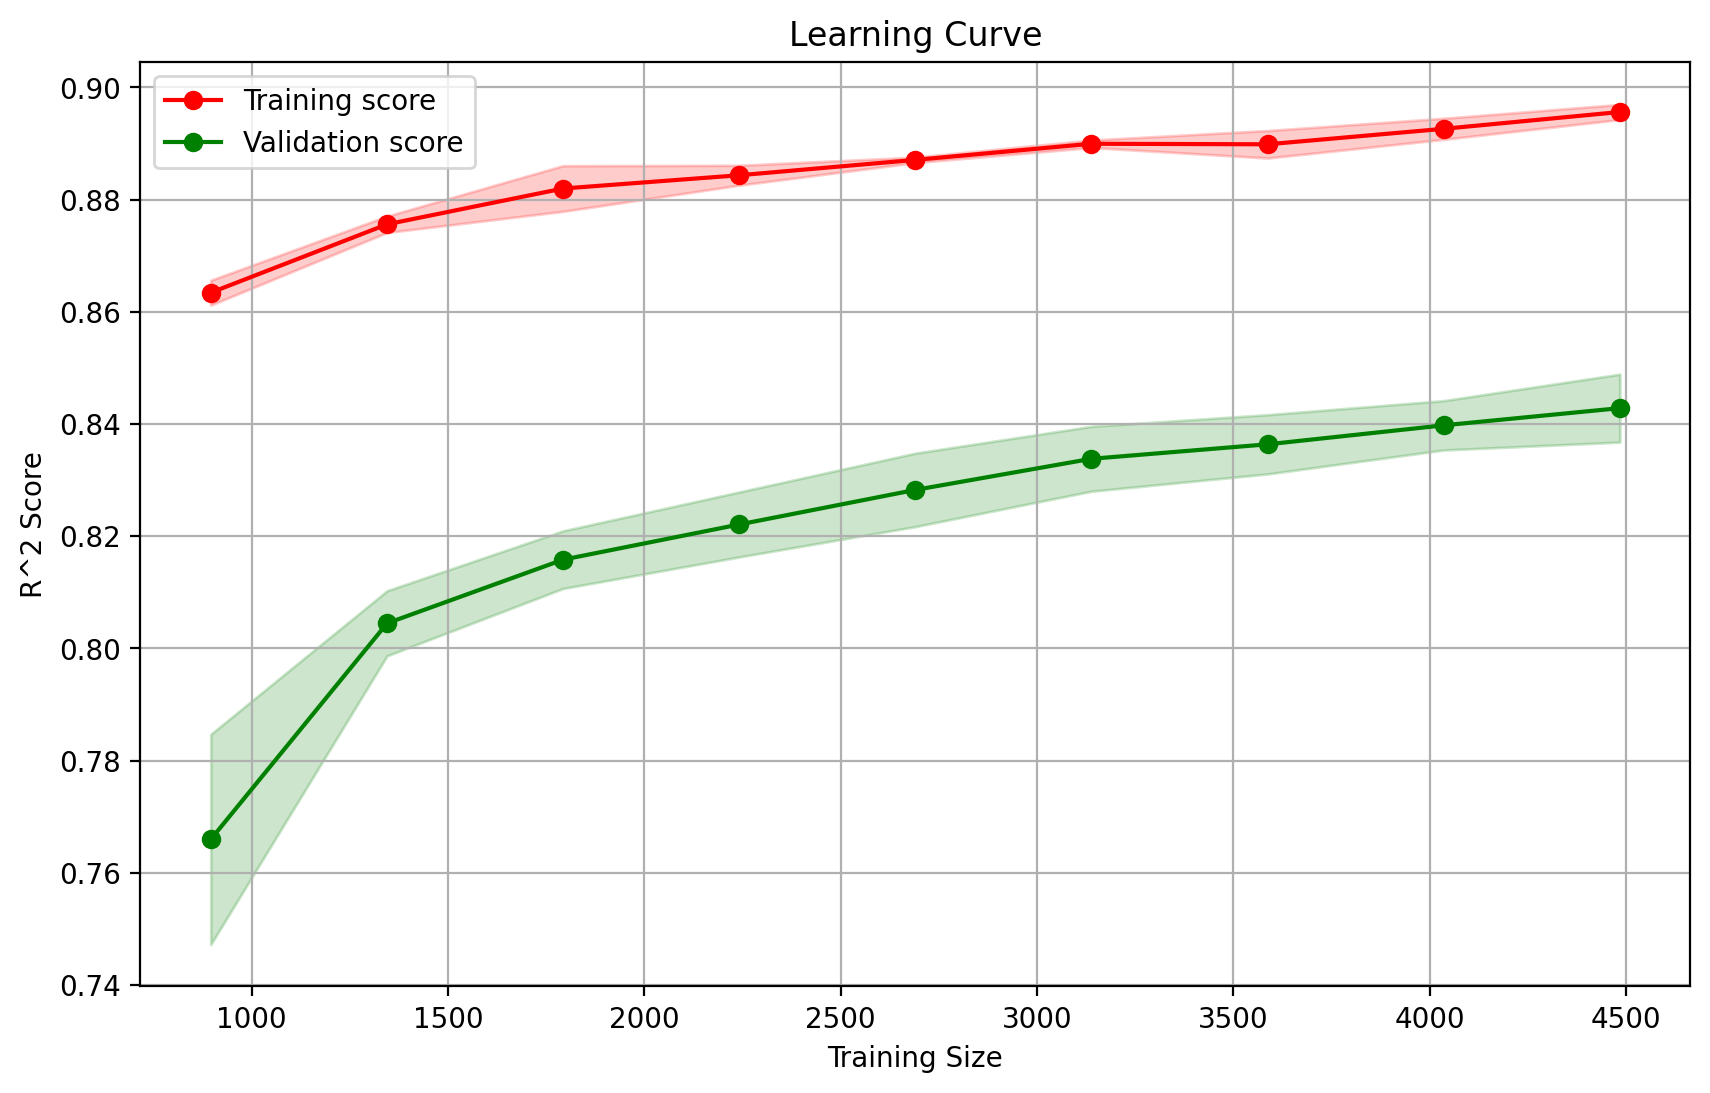

In [23]:
# learning curve를 통한 과대 / 과소적합 파악
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    forest_reg, 
    train_x, 
    train_y, 
    cv=5,                 # 교차 검증 폴드 수
    scoring='r2',         # 성능 평가 지표
    n_jobs=-1,            # 모든 CPU 코어 사용
    train_sizes=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # 학습 데이터의 비율
)

# 결과
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)




# 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation score')

# 신뢰 구간
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.2)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, color='g', alpha=0.2)

plt.xlabel('Training Size')
plt.ylabel('R^2 Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

###### 자료의 개수가 많아질수록 valid의 R2는 미세하게 계속 올라간다

#### GBM

In [46]:
#2 그래디부스트 회귀
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint



grad_reg = GradientBoostingRegressor(random_state=42)
param_distributions = {            
    'learning_rate': uniform(0.01, 0.3),            # 학습률
    'max_depth': randint(3, 30),                    # 트리의 최대 깊이
    'min_samples_split': randint(2, 20),             # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': randint(1, 20),              # 리프 노드에 있어야 하는 최소 샘플 수
    'subsample': uniform(0.5, 0.5)                   # 샘플의 비율 (부트스트랩)
}

random_search = RandomizedSearchCV(estimator=grad_reg, param_distributions=param_distributions,
                           cv=10, n_jobs=-1, verbose=2, scoring='r2')
# 모델 학습
random_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 찾기
print("Best parameters found: ", random_search.best_params_)
print("Best r2 score: {:.2f}".format(random_search.best_score_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters found:  {'learning_rate': 0.09686272986276662, 'max_depth': 18, 'min_samples_leaf': 18, 'min_samples_split': 16, 'subsample': 0.7473568479956525}
Best r2 score: 0.81


In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Gradient Boosting Regressor 모델 정의
grad_reg = GradientBoostingRegressor(random_state=42)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'learning_rate': [0.035,0.04,0.045,0.5],    # 학습률: 0.01부터 0.3까지 연속적인 값
    'max_depth': [20,24,26,28],               # 트리의 최대 깊이
    'min_samples_split': [5,7,9,],         # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': [9,11,13],
    'subsample' : [0.5,0.55,0.6,0.65]  # 리프 노드에 있어야 하는 최소 샘플 수
}

# GridSearchCV 정의
grid_search = GridSearchCV(
    estimator=grad_reg,
    param_grid=param_grid,
    cv=5,            # 교차 검증의 폴드 수를 5로 설정
    n_jobs=-1,       # 모든 CPU 코어 사용
    verbose=2,       # 출력 상세 수준
    scoring='r2'     # 평가 지표
)

# 모델 학습
grid_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best r2 score: {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters found:  {'learning_rate': 0.04, 'max_depth': 20, 'min_samples_leaf': 11, 'min_samples_split': 5, 'subsample': 0.55}
Best r2 score: 0.81


###### {'learning_rate': 0.04, 'max_depth': 20, 'min_samples_leaf': 11, 'min_samples_split': 5, 'subsample': 0.55}를 이용해 GBM모델 생성

In [17]:
grad_reg = GradientBoostingRegressor(random_state = 42, learning_rate= 0.04, max_depth = 20, min_samples_leaf= 11, 
                                     min_samples_split= 5, subsample= 0.55)
grad_reg.fit(train_x,train_y)

GradientBoostingRegressor(learning_rate=0.04, max_depth=20, min_samples_leaf=11,
                          min_samples_split=5, random_state=42, subsample=0.55)

In [45]:
# 예측
y_pred = grad_reg.predict(train_x)
y_pred2 = grad_reg.predict(valid_x)
y_pred2 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred2)).flatten()
    
# 성능 평가

# in train set
mse1 = mean_squared_error(train_y, y_pred)
mae1 = mean_absolute_error(train_y, y_pred)
r21= r2_score(train_y, y_pred)

# in valid set
mse2 = mean_squared_error(valid_y, y_pred2)
mae2 = mean_absolute_error(valid_y, y_pred2)
r22 = r2_score(valid_y, y_pred2)    



# 결과 저장
results = {
    "Metric": ["Mean Squared Error", "Mean Absolute Error", "R^2 Score"],
    "Train Set": [mse1, mae1, r21],
    "Validation Set": [mse2, mae2, r22]
}

# DataFrame으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)

                Metric  Train Set  Validation Set
0   Mean Squared Error   0.055505    71036.641313
1  Mean Absolute Error   0.172122      169.293516
2            R^2 Score   0.944495        0.836934


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


###### Trainset에서는 0.94 valid에서는 0.83 로 나쁘지 않은 성능을 보인다

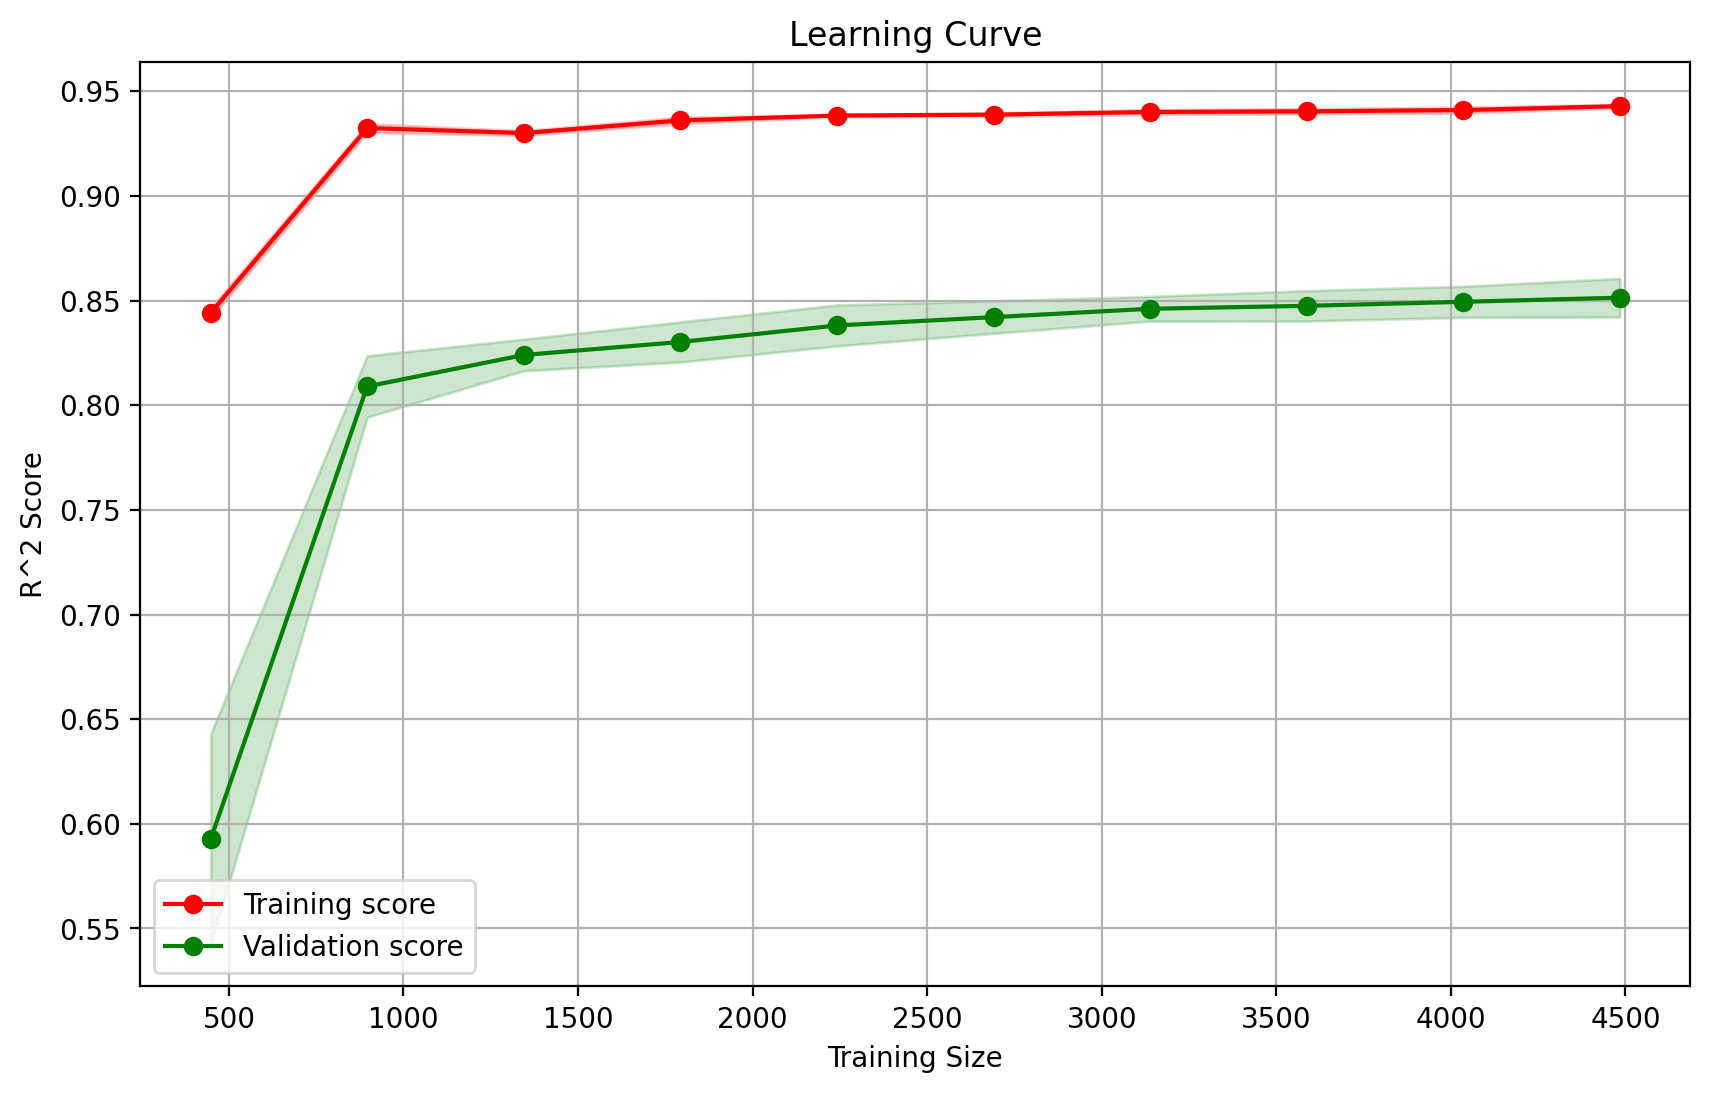

In [46]:
# learning curve를 통한 과대 / 과소적합 파악
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    grad_reg, 
    train_x, 
    train_y, 
    cv=5,                 # 교차 검증 폴드 수
    scoring='r2',         # 성능 평가 지표
    n_jobs=-1,            # 모든 CPU 코어 사용
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # 학습 데이터의 비율
)

# 결과
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)




# 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation score')

# 신뢰 구간
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.2)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, color='g', alpha=0.2)

plt.xlabel('Training Size')
plt.ylabel('R^2 Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

###### 자료의 개수가 1500개이상부터는 큰 차이가 R2 score에 큰 차이가 없는걸로 확인

In [51]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# ElasticNet 모델 정의
elastic_net = ElasticNet()

# 하이퍼파라미터 그리드 정의
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],  # 규제 강도
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0],  # L1 규제와 L2 규제의 비율
    'max_iter': [1000, 5000, 10000],  # 반복 횟수
    'tol': [1e-4, 1e-3, 1e-2],  # 허용 오차
    'selection': ['cyclic', 'random']  # 변수 선택 방법
}

# GridSearchCV 정의
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=5,             # 교차 검증의 폴드 수
    n_jobs=-1,        # 모든 CPU 코어 사용
    verbose=2,        # 출력의 상세 수준
    scoring='r2',     # 평가 지표 (회귀 문제에서는 R^2 점수를 사용)
)

# 모델 학습
grid_search.fit(train_x, train_y)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best r2 score: {:.2f}".format(grid_search.best_score_))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'alpha': 0.001, 'l1_ratio': 0.5, 'max_iter': 1000, 'selection': 'random', 'tol': 0.01}
Best r2 score: 0.69


In [18]:
# 최적의 하이퍼파라미터를 사용하여 ElasticNet 모델 정의
elastic_net = ElasticNet(alpha=0.001,l1_ratio=0.5,max_iter=1000,tol=0.01,selection='random',random_state=42  )

# 모델 학습
elastic_net.fit(train_x, train_y)


ElasticNet(alpha=0.001, random_state=42, selection='random', tol=0.01)

In [54]:
# 예측
y_pred = elastic_net.predict(train_x)
y_pred2 = elastic_net.predict(valid_x)
y_pred2 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred2)).flatten()
    
# 성능 평가

# in train set
mse1 = mean_squared_error(train_y, y_pred)
mae1 = mean_absolute_error(train_y, y_pred)
r21= r2_score(train_y, y_pred)

# in valid set
mse2 = mean_squared_error(valid_y, y_pred2)
mae2 = mean_absolute_error(valid_y, y_pred2)
r22 = r2_score(valid_y, y_pred2)    



# 결과 저장
results = {
    "Metric": ["Mean Squared Error", "Mean Absolute Error", "R^2 Score"],
    "Train Set": [mse1, mae1, r21],
    "Validation Set": [mse2, mae2, r22]
}

# DataFrame으로 변환
results_df = pd.DataFrame(results)

# 결과 출력
print(results_df)

                Metric  Train Set  Validation Set
0   Mean Squared Error   0.305218   154974.510060
1  Mean Absolute Error   0.424425      251.591361
2            R^2 Score   0.694782        0.644253


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


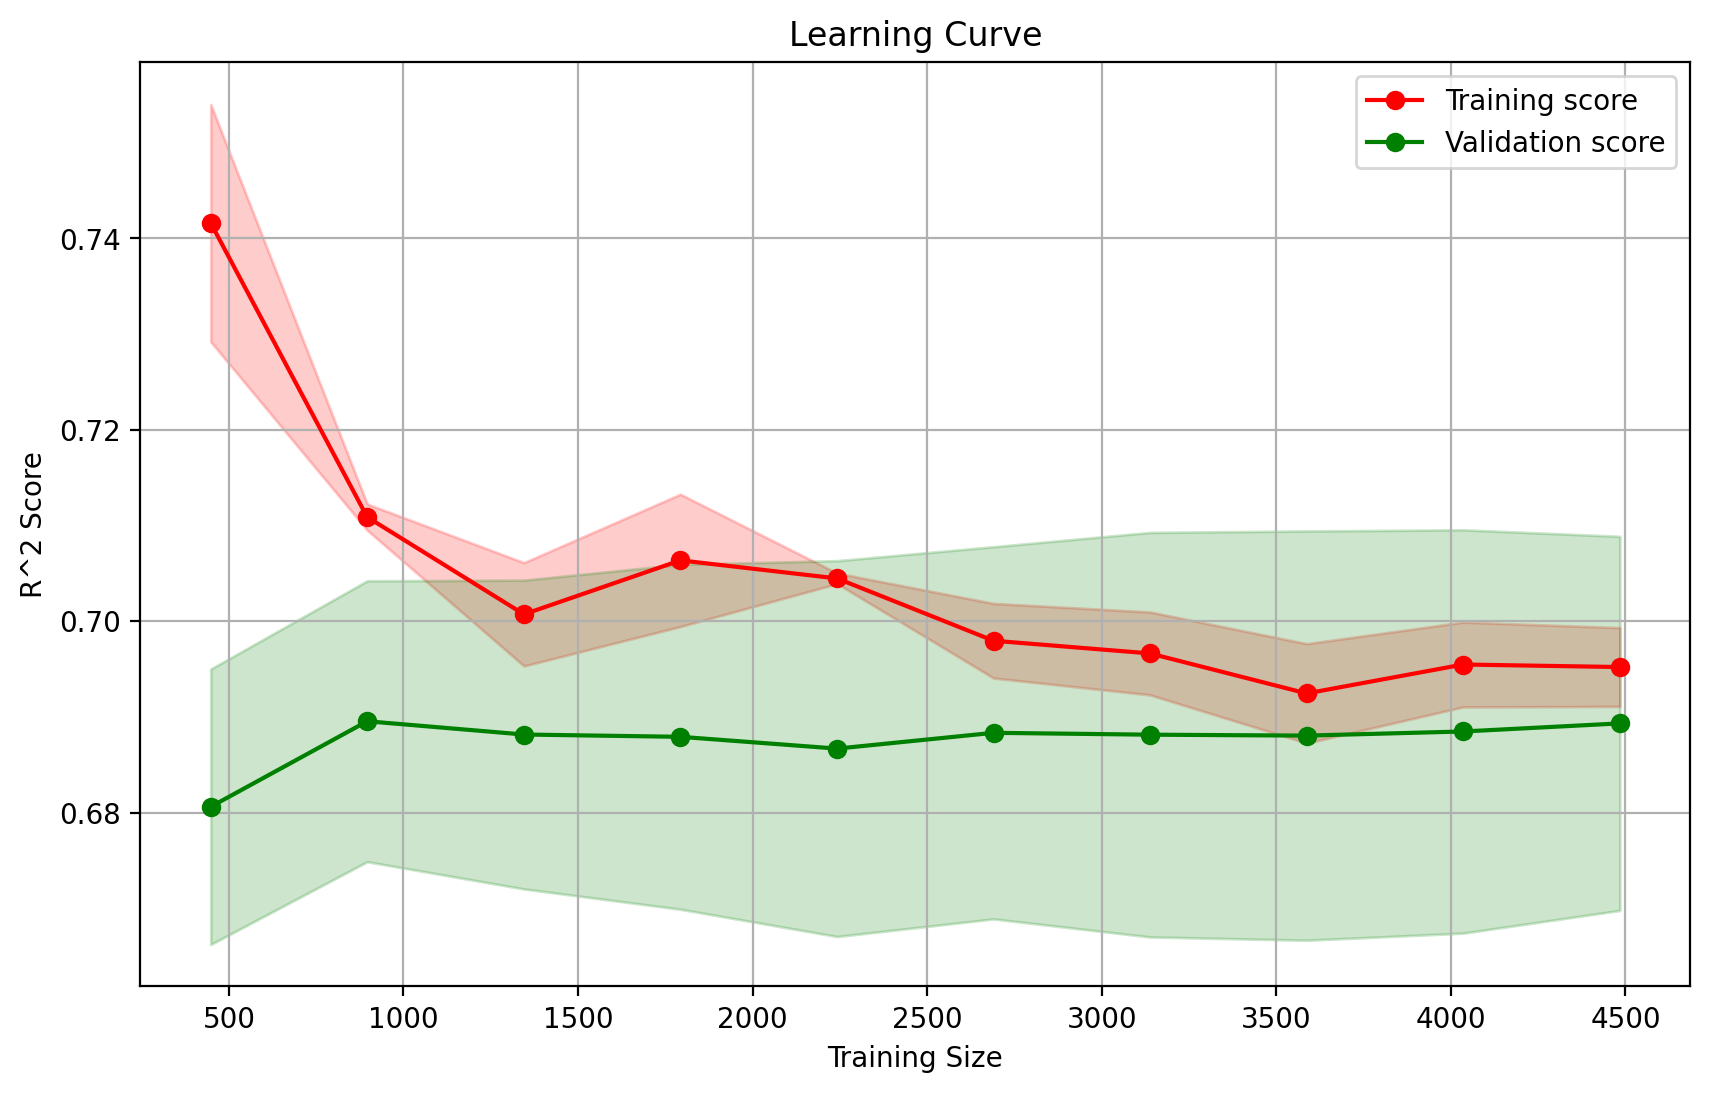

In [57]:
# learning curve를 통한 과대 / 과소적합 파악
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    elastic_net, 
    train_x, 
    train_y, 
    cv=5,                 # 교차 검증 폴드 수
    scoring='r2',         # 성능 평가 지표
    n_jobs=-1,            # 모든 CPU 코어 사용
    train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]  # 학습 데이터의 비율
)

# 결과
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)
valid_scores_std = valid_scores.std(axis=1)




# 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, valid_scores_mean, 'o-', color='g', label='Validation score')

# 신뢰 구간
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color='r', alpha=0.2)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, color='g', alpha=0.2)

plt.xlabel('Training Size')
plt.ylabel('R^2 Score')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

###### 자료 개수가 1000개부터 갑자기 training score가 떨어짐 --?

In [159]:
# 좋은 모델 2개 결과 요약
y_pred1 = forest_reg.predict(valid_x)
y_pred1 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred1)).flatten()
mse1 = mean_squared_error(valid_y, y_pred1)
mae1 = mean_absolute_error(valid_y, y_pred1)
r21 = r2_score(valid_y, y_pred1)


y_pred2 = grad_reg.predict(valid_x)
y_pred2 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred2)).flatten()
mse2 = mean_squared_error(valid_y, y_pred2)
mae2 = mean_absolute_error(valid_y, y_pred2)
r22 = r2_score(valid_y, y_pred2)


results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'MSE': [mse1, mse2],
    'MAE': [mae1, mae2],
    'R²': [r21, r22]
})

print(results)


               Model           MSE         MAE        R²
0      Random Forest  75899.187839  176.434433  0.825772
1  Gradient Boosting  71036.641313  169.293516  0.836934


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


### testset으로 모델평가

In [31]:
test = pd.read_csv('C:/Users/user/OneDrive/바탕 화면/비어플/test.csv',encoding='EUC-KR')
test

,Date,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,11/07/2018,22,27.1,79,1.2,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes
1,28/11/2018,11,5.7,15,1.1,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes
2,18/04/2018,15,19.0,21,3.3,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes
3,09/03/2018,14,8.0,42,NaN,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes
4,28/10/2018,16,12.2,65,1.9,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,08/05/2018,7,15.3,60,2.0,2000,7.5,0.35,0.0,0.0,Spring,No Holiday,Yes
1748,19/03/2018,17,8.5,59,2.7,1927,0.9,0.16,0.0,0.0,Spring,No Holiday,Yes
1749,04/10/2018,20,21.3,53,1.8,2000,11.3,0.00,0.0,0.0,Autumn,No Holiday,No
1750,08/10/2018,12,19.2,31,0.5,1994,1.6,2.40,0.0,0.0,Autumn,No Holiday,Yes


In [34]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       1752 non-null   object 
 1   Hour                       1752 non-null   int64  
 2   Temperature(°C)            1578 non-null   float64
 3   Humidity(%)                1752 non-null   int64  
 4   Wind speed (m/s)           1581 non-null   float64
 5   Visibility (10m)           1752 non-null   int64  
 6   Dew point temperature(°C)  1752 non-null   float64
 7   Solar Radiation (MJ/m2)    1752 non-null   float64
 8   Rainfall(mm)               1752 non-null   float64
 9   Snowfall (cm)              1752 non-null   float64
 10  Seasons                    1575 non-null   object 
 11  Holiday                    1752 non-null   object 
 12  Functioning Day            1752 non-null   object 
dtypes: float64(6), int64(3), object(4)
memory usage:

In [35]:
test.isna().sum()

Date                           0
Hour                           0
Temperature(°C)              174
Humidity(%)                    0
Wind speed (m/s)             171
Visibility (10m)               0
Dew point temperature(°C)      0
Solar Radiation (MJ/m2)        0
Rainfall(mm)                   0
Snowfall (cm)                  0
Seasons                      177
Holiday                        0
Functioning Day                0
dtype: int64

In [43]:
# 열 이름 변경
test = test.rename(columns={'Temperature(°C)': 'Temperature(째C)'})
test = test.rename(columns={'Dew point temperature(°C)': 'Dew point temperature(째C)'})


# 결과 확인
print(test.head())

        Date  Hour  Temperature(째C)  Humidity(%)  Wind speed (m/s)  \
0 2018-07-11    22             27.1           79               1.2   
1 2018-11-28    11              5.7           15               1.1   
2 2018-04-18    15             19.0           21               3.3   
3 2018-03-09    14              8.0           42               2.6   
4 2018-10-28    16             12.2           65               1.9   

   Visibility (10m)  Dew point temperature(째C)  Solar Radiation (MJ/m2)  \
0              1578                       23.1                     0.00   
1              1419                      -19.0                     0.98   
2              1716                       -3.8                     2.88   
3              1690                       -4.1                     1.24   
4              2000                        5.8                     0.52   

   Rainfall(mm)  Snowfall (cm) Seasons     Holiday Functioning Day    Daytime  \
0           0.0            0.0  Summer  No Holi

#### test셋도 trainset에 맞춰서 전처리

In [44]:
#계절 결측치를 월에 맞춰서 결측치 대체
#Datetime 형식으로 변환
test['Date'] = pd.to_datetime(test['Date'], format='%d/%m/%Y', errors='coerce')
# 계절 결측치를 월에 맞춰서 대체
test.loc[test['Date'].dt.month.isin([12, 1, 2]), 'Seasons'] = 'Winter'
test.loc[test['Date'].dt.month.isin([3, 4, 5]), 'Seasons'] = 'Spring'
test.loc[test['Date'].dt.month.isin([6, 7, 8]), 'Seasons'] = 'Summer'
test.loc[test['Date'].dt.month.isin([9, 10,11]), 'Seasons'] = 'Autumn'

# 원래 인덱스를 유지한 채로 선형 보간법을 적용
test['Temperature(째C)'] = test['Temperature(째C)'].interpolate(method='linear', limit_direction='both')
test['Wind speed (m/s)'] = test['Wind speed (m/s)'].interpolate(method='linear', limit_direction='both')

# 결과 출력
print(test)


def classify_hour(hour):
    if 0 <= hour < 6:
        return 'Dawn'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

test['Daytime'] = test['Hour'].apply(classify_hour)
test


           Date  Hour  Temperature(째C)  Humidity(%)  Wind speed (m/s)  \
0    2018-07-11    22             27.1           79               1.2   
1    2018-11-28    11              5.7           15               1.1   
2    2018-04-18    15             19.0           21               3.3   
3    2018-03-09    14              8.0           42               2.6   
4    2018-10-28    16             12.2           65               1.9   
...         ...   ...              ...          ...               ...   
1747 2018-05-08     7             15.3           60               2.0   
1748 2018-03-19    17              8.5           59               2.7   
1749 2018-10-04    20             21.3           53               1.8   
1750 2018-10-08    12             19.2           31               0.5   
1751 2018-07-19    15             33.7           41               0.5   

      Visibility (10m)  Dew point temperature(째C)  Solar Radiation (MJ/m2)  \
0                 1578                       

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Daytime,T-H
0,2018-07-11,22,27.1,79,1.2,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes,Evening,22.9
1,2018-11-28,11,5.7,15,1.1,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes,Morning,-11.3
2,2018-04-18,15,19.0,21,3.3,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes,Afternoon,3.2
3,2018-03-09,14,8.0,42,2.6,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes,Afternoon,-3.6
4,2018-10-28,16,12.2,65,1.9,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes,Afternoon,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2018-05-08,7,15.3,60,2.0,2000,7.5,0.35,0.0,0.0,Spring,No Holiday,Yes,Morning,7.3
1748,2018-03-19,17,8.5,59,2.7,1927,0.9,0.16,0.0,0.0,Spring,No Holiday,Yes,Afternoon,0.3
1749,2018-10-04,20,21.3,53,1.8,2000,11.3,0.00,0.0,0.0,Autumn,No Holiday,No,Evening,11.9
1750,2018-10-08,12,19.2,31,0.5,1994,1.6,2.40,0.0,0.0,Autumn,No Holiday,Yes,Afternoon,5.4


In [45]:
test['T-H'] =test['Temperature(째C)'] - (100-test['Humidity(%)'])/5

In [46]:
test

,Date,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Daytime,T-H
0,2018-07-11,22,27.1,79,1.2,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes,Evening,22.9
1,2018-11-28,11,5.7,15,1.1,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes,Morning,-11.3
2,2018-04-18,15,19.0,21,3.3,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes,Afternoon,3.2
3,2018-03-09,14,8.0,42,2.6,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes,Afternoon,-3.6
4,2018-10-28,16,12.2,65,1.9,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes,Afternoon,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,2018-05-08,7,15.3,60,2.0,2000,7.5,0.35,0.0,0.0,Spring,No Holiday,Yes,Morning,7.3
1748,2018-03-19,17,8.5,59,2.7,1927,0.9,0.16,0.0,0.0,Spring,No Holiday,Yes,Afternoon,0.3
1749,2018-10-04,20,21.3,53,1.8,2000,11.3,0.00,0.0,0.0,Autumn,No Holiday,No,Evening,11.9
1750,2018-10-08,12,19.2,31,0.5,1994,1.6,2.40,0.0,0.0,Autumn,No Holiday,Yes,Afternoon,5.4


In [47]:
testset = test.drop(columns=['Date'], axis = 1)

In [48]:
testset

,Hour,Temperature(째C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(째C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Daytime,T-H
0,22,27.1,79,1.2,1578,23.1,0.00,0.0,0.0,Summer,No Holiday,Yes,Evening,22.9
1,11,5.7,15,1.1,1419,-19.0,0.98,0.0,0.0,Autumn,No Holiday,Yes,Morning,-11.3
2,15,19.0,21,3.3,1716,-3.8,2.88,0.0,0.0,Spring,No Holiday,Yes,Afternoon,3.2
3,14,8.0,42,2.6,1690,-4.1,1.24,0.0,0.0,Spring,No Holiday,Yes,Afternoon,-3.6
4,16,12.2,65,1.9,2000,5.8,0.52,0.0,0.0,Autumn,No Holiday,Yes,Afternoon,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,7,15.3,60,2.0,2000,7.5,0.35,0.0,0.0,Spring,No Holiday,Yes,Morning,7.3
1748,17,8.5,59,2.7,1927,0.9,0.16,0.0,0.0,Spring,No Holiday,Yes,Afternoon,0.3
1749,20,21.3,53,1.8,2000,11.3,0.00,0.0,0.0,Autumn,No Holiday,No,Evening,11.9
1750,12,19.2,31,0.5,1994,1.6,2.40,0.0,0.0,Autumn,No Holiday,Yes,Afternoon,5.4


In [49]:
# valid data 전처리
test_x = preprocessing.transform(testset)
feature_names = preprocessing.get_feature_names_out()
test_x= pd.DataFrame(data = test_x, columns = feature_names)
test_x

,num__Temperature(째C),num__Humidity(%),num__Wind speed (m/s),num__Visibility (10m),num__Dew point temperature(째C),num__Solar Radiation (MJ/m2),num__Rainfall(mm),num__Snowfall (cm),num__T-H,onehot__Seasons_Autumn,...,onehot__Seasons_Summer,onehot__Seasons_Winter,onehot__Holiday_Holiday,onehot__Holiday_No Holiday,onehot__Functioning Day_No,onehot__Functioning Day_Yes,onehot__Daytime_Afternoon,onehot__Daytime_Dawn,onehot__Daytime_Evening,onehot__Daytime_Morning
0,1.182640,1.021090,-0.508880,0.227946,1.453139,-0.657110,-0.127513,-0.168463,1.384268,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.605675,-2.123795,-0.606592,-0.033459,-1.769428,0.451941,-0.127513,-0.168463,-1.201582,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.505754,-1.828962,1.543082,0.454826,-0.605936,2.602144,-0.127513,-0.168463,-0.105242,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
3,-0.413473,-0.797047,0.859095,0.412081,-0.628900,0.746180,-0.127513,-0.168463,-0.619388,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.062495,0.333147,0.175107,0.921739,0.128901,-0.068634,-0.127513,-0.168463,0.045977,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747,0.196560,0.087452,0.272820,0.921739,0.259029,-0.261020,-0.127513,-0.168463,0.204758,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1748,-0.371690,0.038314,0.956807,0.801723,-0.246172,-0.476041,-0.127513,-0.168463,-0.324510,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
1749,0.697957,-0.256519,0.077395,0.921739,0.549902,-0.657110,-0.127513,-0.168463,0.552562,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1750,0.522468,-1.337574,-1.192867,0.911875,-0.192590,2.058935,-0.127513,-0.168463,0.061099,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [50]:
y_pred1 = forest_reg.predict(test_x)
y_pred1 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred1)).flatten()


y_pred2 = grad_reg.predict(test_x)
y_pred2 = yeojohnson_y.inverse_transform(pd.DataFrame(y_pred2)).flatten()


c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
c:\Users\user\miniconda3\envs\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


<Axes: ylabel='Count'>

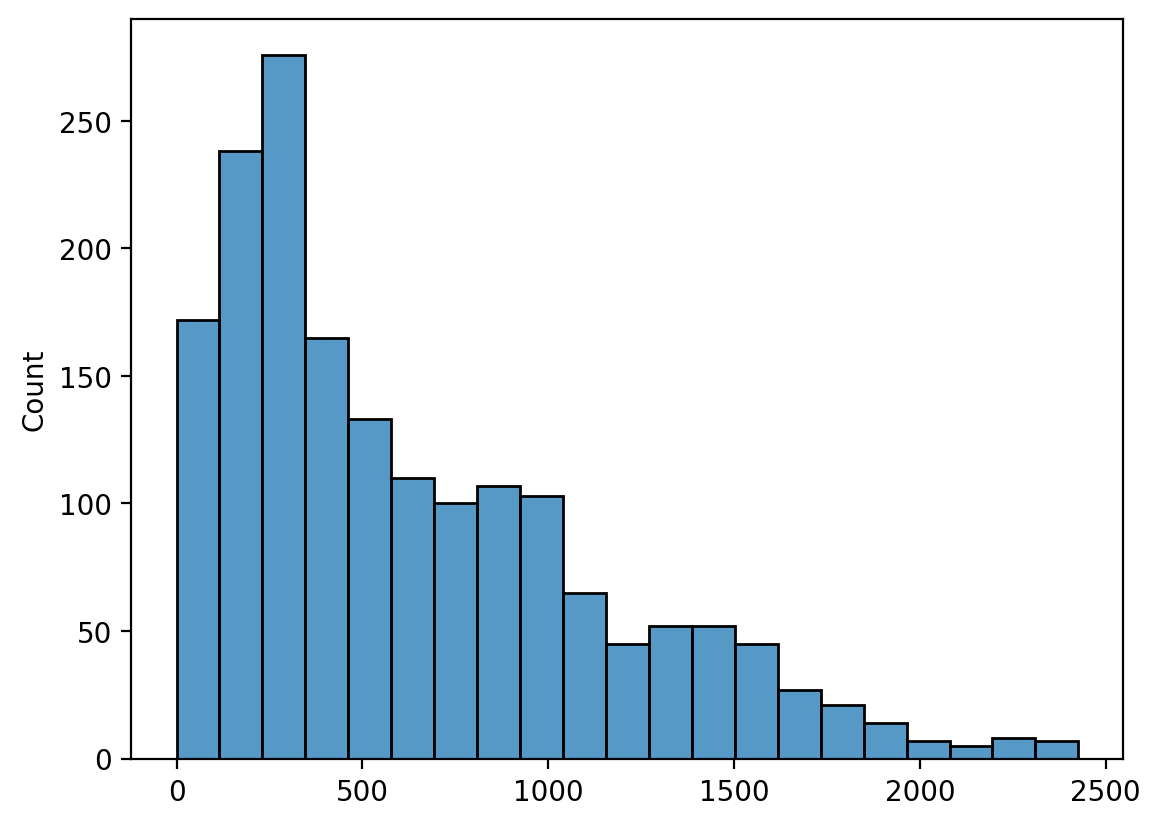

In [51]:
sns.histplot(y_pred1)

<Axes: ylabel='Count'>

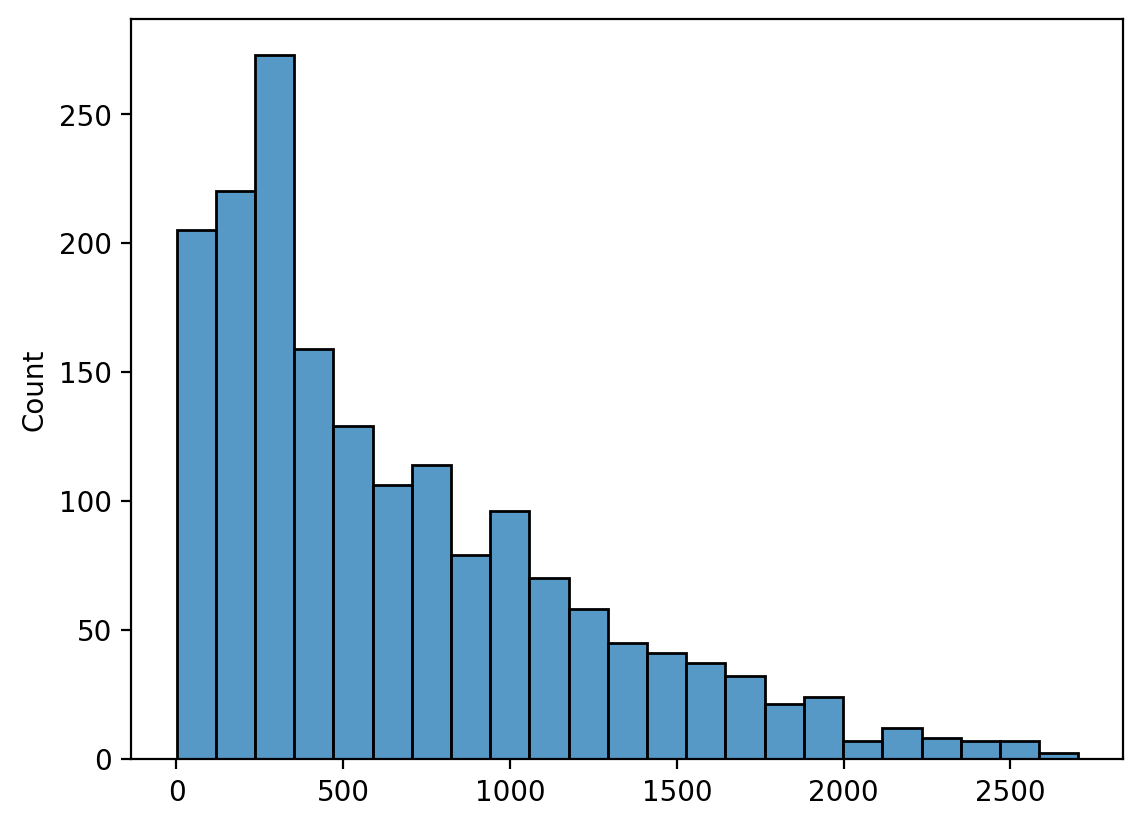

In [52]:
sns.histplot(y_pred2)

In [53]:
y_pred1 = pd.DataFrame(y_pred1)
y_pred2 = pd.DataFrame(y_pred2)

In [54]:
y_pred1.to_csv('예측rf.csv', index=False)
y_pred2.to_csv('예측gb.csv', index=False)